In [2]:
# Check GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ============================================
# **PART 1: DATA PREPROCESSING AND CLEANING**
#============================================

# 1. Import required libraries
# (pandas, numpy, seaborn, matplotlib, sklearn, etc.)


In [3]:
!pip install missingno shap lime xgboost tensorflow keras plotly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5cac22db8955fcccdd8dd757d65b1f41308a846d76c82386dc2bd2a6dd3c3e04
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats


# 2. Load CSV filest
# (DoS, Malfunction, Normal) and merge into one dataframe


In [5]:
from google.colab import files
uploaded = files.upload()


Saving Dos1.csv to Dos1.csv
Saving Dos2.csv to Dos2.csv
Saving Malfunction1.csv to Malfunction1.csv
Saving Malfunction2.csv to Malfunction2.csv
Saving Normal1.csv to Normal1.csv
Saving Normal2.csv to Normal2.csv
Saving Normal3.csv to Normal3.csv
Saving Normal4.csv to Normal4.csv


In [6]:
!ls -lh /content


total 16M
-rw-r--r-- 1 root root 2.9M Dec  9 09:08 Dos1.csv
-rw-r--r-- 1 root root 544K Dec  9 09:08 Dos2.csv
-rw-r--r-- 1 root root 1.6M Dec  9 09:08 Malfunction1.csv
-rw-r--r-- 1 root root 1.7M Dec  9 09:08 Malfunction2.csv
-rw-r--r-- 1 root root 2.1M Dec  9 09:08 Normal1.csv
-rw-r--r-- 1 root root 3.1M Dec  9 09:08 Normal2.csv
-rw-r--r-- 1 root root 2.6M Dec  9 09:08 Normal3.csv
-rw-r--r-- 1 root root 1.1M Dec  9 09:08 Normal4.csv
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data


In [8]:
import os
import pandas as pd


path = './'

dos_files = ['Dos1.csv', 'Dos2.csv']
mal_files = ['Malfunction1.csv', 'Malfunction2.csv']
normal_files = ['Normal1.csv', 'Normal2.csv', 'Normal3.csv', 'Normal4.csv']

def load_and_label(files, label):
    dfs = []
    for f in files:
        file_path = os.path.join(path, f)
        print("Loading:", file_path)
        df = pd.read_csv(file_path)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df['Label'] = label
    return df

dos = load_and_label(dos_files, 'DoS_Attack')
mal = load_and_label(mal_files, 'Malfunction')
normal = load_and_label(normal_files, 'Normal')

data = pd.concat([dos, mal, normal], ignore_index=True)
print("✅ Data combined successfully. Shape:", data.shape)


Loading: ./Dos1.csv
Loading: ./Dos2.csv
Loading: ./Malfunction1.csv
Loading: ./Malfunction2.csv
Loading: ./Normal1.csv
Loading: ./Normal2.csv
Loading: ./Normal3.csv
Loading: ./Normal4.csv
✅ Data combined successfully. Shape: (87417, 80)


In [9]:
data.head()


,S.No,setpoint_raw-global_Time,setpoint_raw-global_header.seq,setpoint_raw-global_header.stamp.secs,setpoint_raw-global_latitude,setpoint_raw-global_longitude,setpoint_raw-global_altitude,battery_Time,battery_header.seq,battery_header.stamp.secs,...,state_manual_input,state_system_status,RSSI_Time,RSSI_Quality,RSSI_Signal,CPU_Time,CPU_Percent,RAM_Time,Used_RAM_MB,Label
0,0,1.729405e+09,1,0,33.69785,73.016496,1.25,1.729405e+09,4605.0,1.729405e+09,...,1.0,5.0,1.729405e+09,1.0,-39.0,1.729405e+09,15.2,1.729405e+09,5.6,DoS_Attack
1,1,1.729405e+09,2,0,33.69785,73.016496,1.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DoS_Attack
2,2,1.729405e+09,3,0,33.69785,73.016496,1.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DoS_Attack
3,3,1.729405e+09,4,0,33.69785,73.016496,1.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DoS_Attack
4,4,1.729405e+09,5,0,33.69785,73.016496,1.25,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DoS_Attack


In [10]:
print("Columns:", data.columns.tolist())
print("\nClass Distribution:\n", data['Label'].value_counts())


Columns: ['S.No', 'setpoint_raw-global_Time', 'setpoint_raw-global_header.seq', 'setpoint_raw-global_header.stamp.secs', 'setpoint_raw-global_latitude', 'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude', 'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs', 'battery_voltage', 'battery_current', 'battery_temperature', 'battery_percentage', 'global_position-local_Time', 'global_position-local_header.seq', 'global_position-local_header.stamp.secs', 'global_position-local_pose.pose.position.x', 'global_position-local_pose.pose.position.y', 'global_position-local_pose.pose.position.z', 'global_position-local_pose.pose.orientation.x', 'global_position-local_pose.pose.orientation.y', 'global_position-local_pose.pose.orientation.z', 'global_position-local_twist.twist.linear.x', 'global_position-local_twist.twist.linear.y', 'global_position-local_twist.twist.linear.z', 'imu-data_Time', 'imu-data_header.seq', 'imu-data_header.stamp.secs', 'imu-data_orientation.x', 'imu

# 3. Exploratory Data Analysis (EDA) - Correlation Heatmap and Feature Distributions

# . Handle missing values (imputation or fillna)
# . Outlier detection and removal
# . Encode categorical labels and apply feature scaling (StandardScaler)
# . Split dataset into Train and Test sets (Stratified Split)




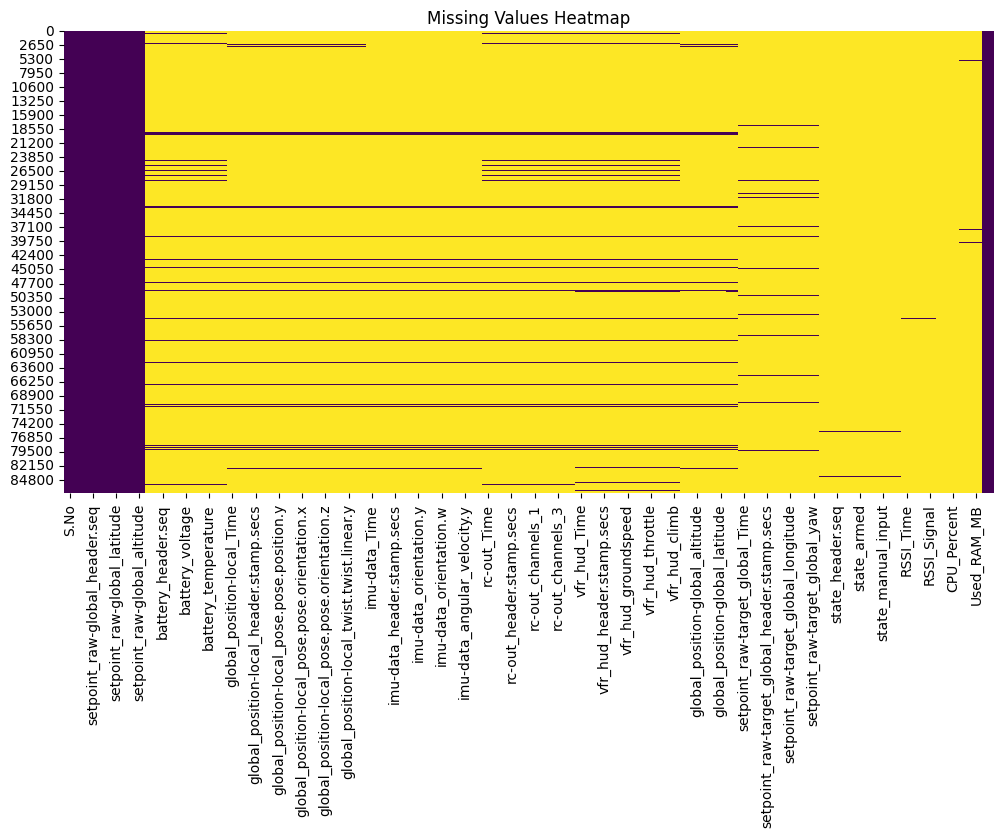

In [11]:
# --- Missing Value Visualization Section ---
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Visualize missing data
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

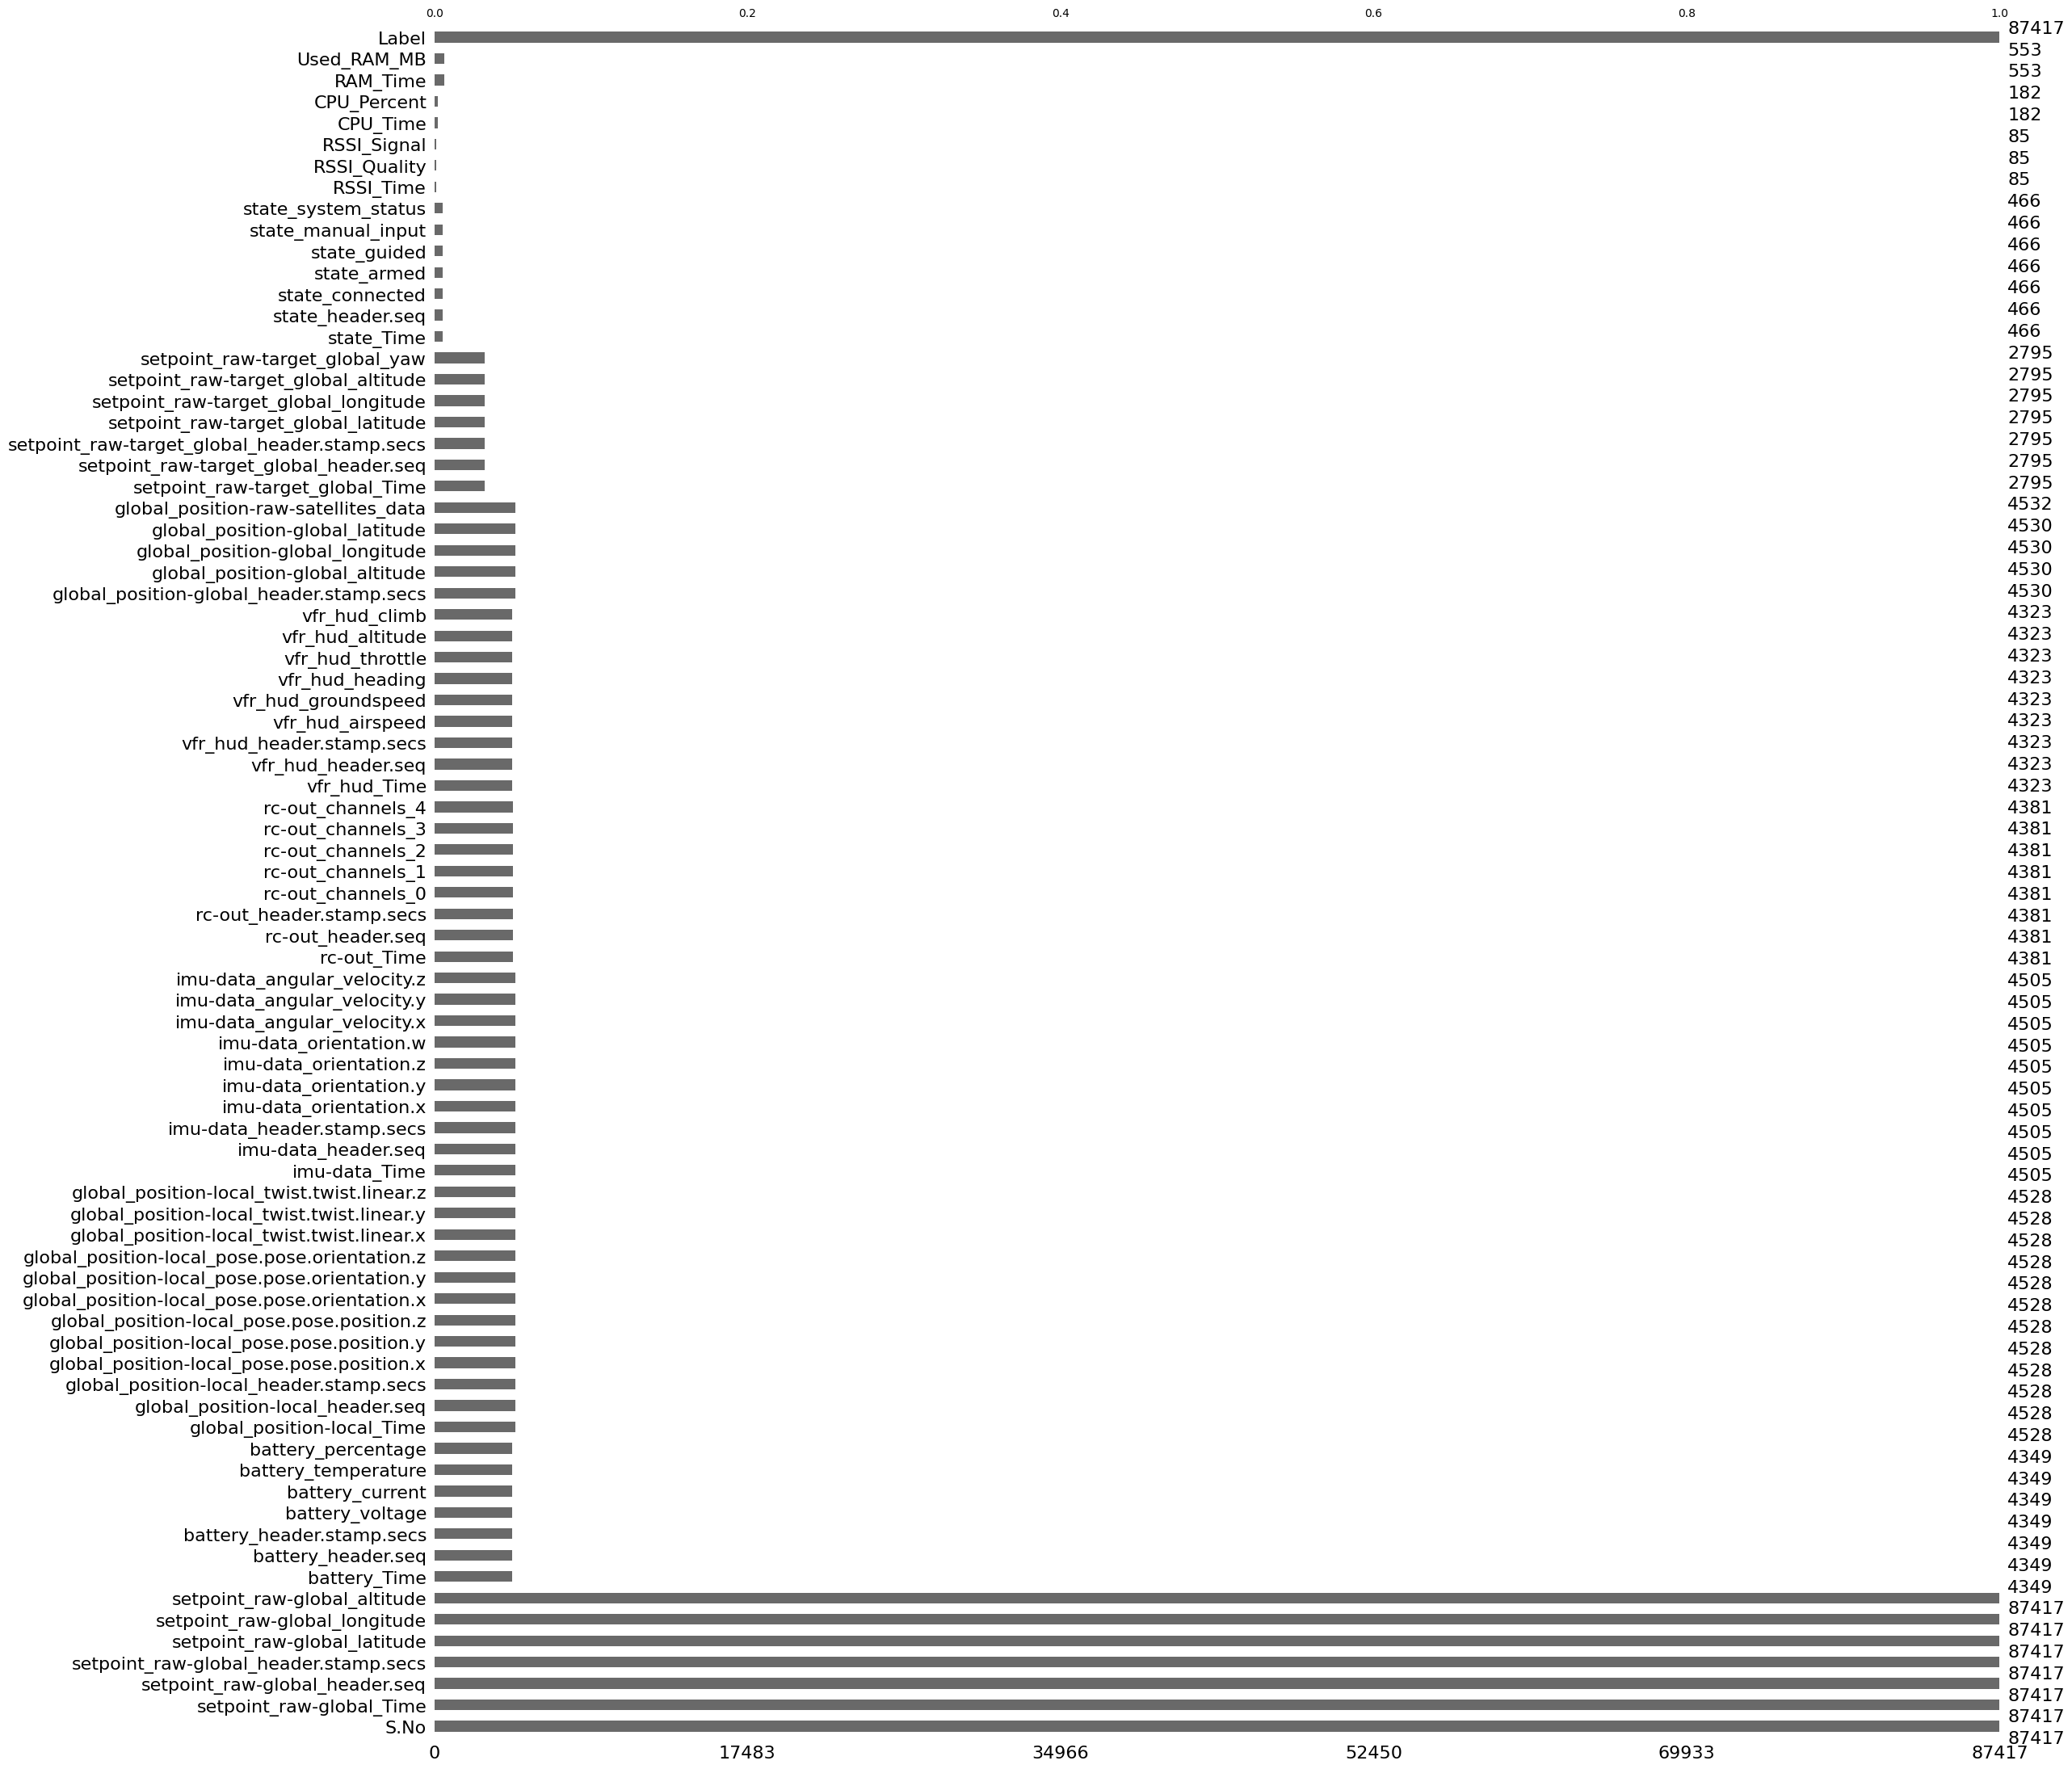

In [12]:
msno.bar(data)
plt.show()

# Fill numeric missing values with median
data.fillna(data.median(numeric_only=True), inplace=True)


In [13]:
numeric_cols = data.select_dtypes(include=[np.number]).columns

z = np.abs(stats.zscore(data[numeric_cols]))
# Calculate fraction of columns that are outliers per row
row_outlier_fraction = (z > 3).sum(axis=1) / z.shape[1]

# Keep rows where <10% features are extreme
data = data[row_outlier_fraction < 0.1]

print("Shape after relaxed outlier removal:", data.shape)


Shape after relaxed outlier removal: (83058, 80)


/tmp/ipython-input-1846668743.py:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z = np.abs(stats.zscore(data[numeric_cols]))
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:11002: RuntimeWarning: overflow encountered in multiply
  var = _xp_mean(x_mean * x_mean_conj, keepdims=keepdims, **kwargs)


Plotting features: ['battery_voltage', 'RSSI_Signal', 'CPU_Percent']


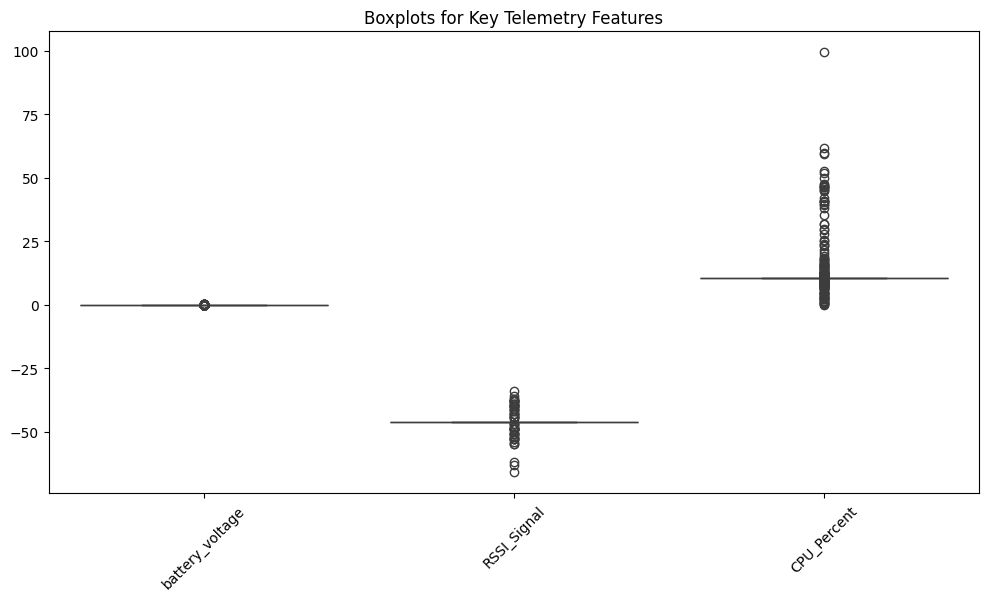

In [14]:
# --- Outlier Visualization Section ---

import seaborn as sns
import matplotlib.pyplot as plt

# Select a few important numeric telemetry features to visualize
features_to_plot = ['battery_voltage', 'RSSI_Signal', 'CPU_Percent']

# Check that these columns exist (in case of typos)
features_to_plot = [f for f in features_to_plot if f in data.columns]
print("Plotting features:", features_to_plot)

plt.figure(figsize=(12, 6))
sns.boxplot(data=data[features_to_plot])
plt.title("Boxplots for Key Telemetry Features")
plt.xticks(rotation=45)
plt.show()


In [15]:
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist()[:10])
print("Sample rows:")
print(data.head())


Data shape: (83058, 80)
Columns: ['S.No', 'setpoint_raw-global_Time', 'setpoint_raw-global_header.seq', 'setpoint_raw-global_header.stamp.secs', 'setpoint_raw-global_latitude', 'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude', 'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs']
Sample rows:
   S.No  setpoint_raw-global_Time  setpoint_raw-global_header.seq  \
1     1              1.729405e+09                               2   
2     2              1.729405e+09                               3   
3     3              1.729405e+09                               4   
4     4              1.729405e+09                               5   
5     5              1.729405e+09                               6   

   setpoint_raw-global_header.stamp.secs  setpoint_raw-global_latitude  \
1                                      0                      33.69785   
2                                      0                      33.69785   
3                                      0 

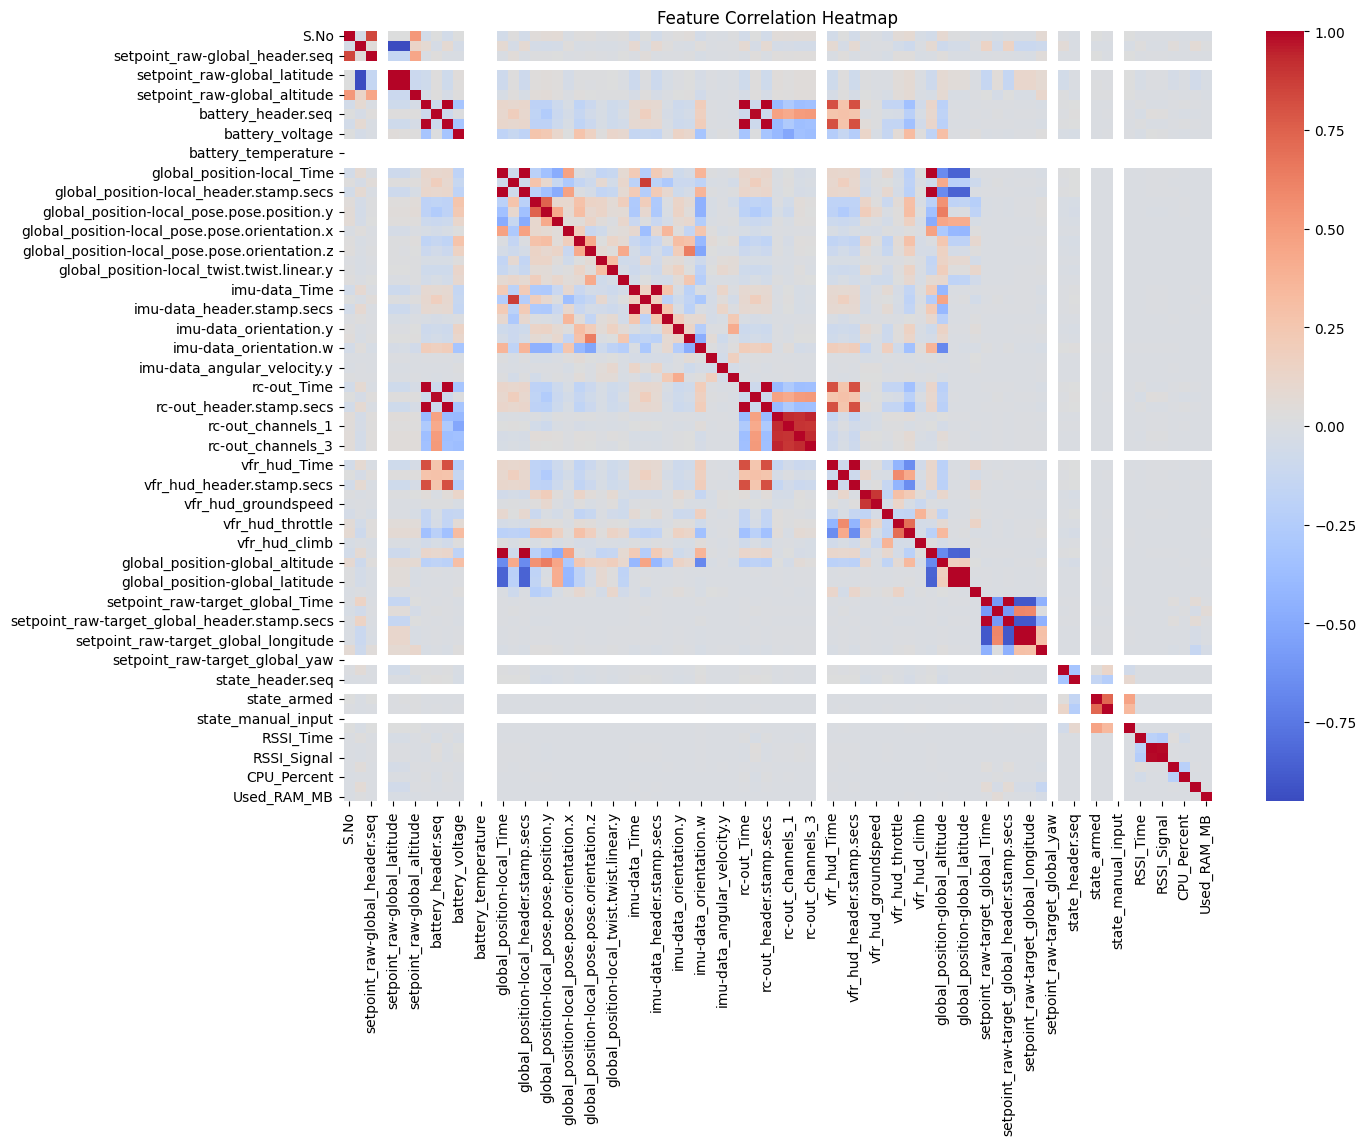

In [16]:
# --- Correlation Heatmap Section ---
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [17]:
# Fill missing values
data.fillna(data.median(numeric_only=True), inplace=True)

# Skip outlier removal
print("Outlier removal skipped — keeping all records (important for anomaly patterns).")

# Encode + scale
from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])

scaler = StandardScaler()
num_cols = data.select_dtypes(include=['float64','int64']).columns.drop('Label')
data[num_cols] = scaler.fit_transform(data[num_cols])

print("Data shape after scaling:", data.shape)
print("Classes:", list(le.classes_))


Outlier removal skipped — keeping all records (important for anomaly patterns).
Data shape after scaling: (83058, 80)
Classes: ['DoS_Attack', 'Malfunction', 'Normal']


In [18]:
from sklearn.model_selection import train_test_split

X = data.drop('Label', axis=1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (66446, 79)
Test shape: (16612, 79)


# ============================================
# **PART** **2: MODEL TRAINING**  & **PART 3:** **MODEL EVALUATION AND COMPARISON**
# ============================================

# This section covers model training for:
# - 1D Convolutional Neural Network (1D-CNN)
# - Feedforward Neural Network (FNN)
# - XGBoost (Gradient Boosted Trees)
# - Evaluate all trained models using metrics:
# - Accuracy, Precision, Recall, F1-Score, and Confusion Matrix

# ============================================






In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# --- Model 1: 1D-CNN Training ---
# Define architecture, compile, train, and save results


In [20]:
X_train_cnn = np.expand_dims(X_train.values, axis=2)
X_test_cnn  = np.expand_dims(X_test.values, axis=2)

print("CNN input shapes:")
print("Train:", X_train_cnn.shape)
print("Test :", X_test_cnn.shape)


CNN input shapes:
Train: (66446, 79, 1)
Test : (16612, 79, 1)


In [21]:
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(79,1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')   # 3 classes
])

model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 77, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 36, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 18, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,155 (1.23 MB)

 Trainable params: 320,771 (1.22 MB)

 Non-trainable params: 384 (1.50 KB)

In [22]:
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=64,
    verbose=1
)


Epoch 1/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8636 - loss: 0.4221 - val_accuracy: 0.9499 - val_loss: 0.1567
Epoch 2/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9709 - loss: 0.0823 - val_accuracy: 0.9656 - val_loss: 0.1575
Epoch 3/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9715 - loss: 0.0810 - val_accuracy: 0.9761 - val_loss: 0.0754
Epoch 4/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9777 - loss: 0.0574 - val_accuracy: 0.9388 - val_loss: 0.1268
Epoch 5/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9816 - loss: 0.0468 - val_accuracy: 0.9768 - val_loss: 0.0899
Epoch 6/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9791 - loss: 0.0555 - val_accuracy: 0.9290 - val_loss: 0.1366
Epoch 7/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9811 - loss: 0.0424 - val_accuracy: 0.9764 - val_loss: 0.0676
Epoch 8/25
831/831 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9804 - loss: 0.0422 - val_accuracy: 0

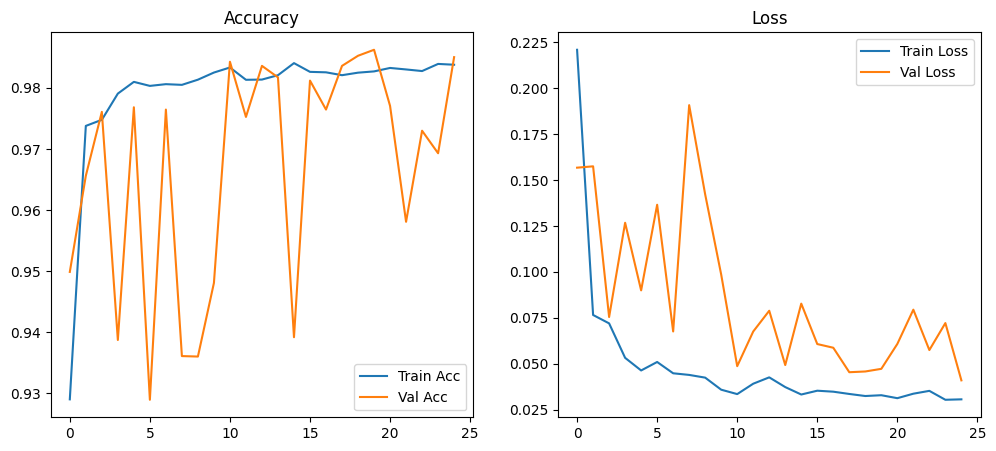

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()
plt.show()


520/520 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.9845894534071755

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      3786
           1       0.96      1.00      0.98      3352
           2       1.00      0.99      0.99      9474

    accuracy                           0.98     16612
   macro avg       0.98      0.98      0.98     16612
weighted avg       0.98      0.98      0.98     16612



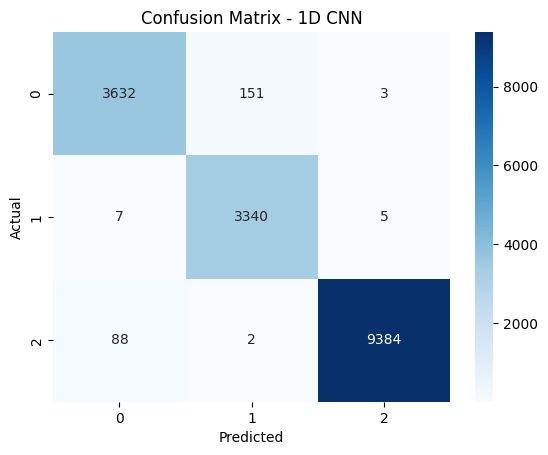

In [24]:
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn), axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_cnn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cnn))

cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix - 1D CNN')
plt.show()


In [25]:
model_cnn.save('/content/drive/MyDrive/ML_Assignment/model_1dcnn.h5')
print("Model saved successfully!")


Model saved successfully!


# --- Model 2: XGBoost Training ---



In [26]:
!pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    eval_metric='mlogloss'
)


In [28]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3786
           1       1.00      1.00      1.00      3352
           2       1.00      1.00      1.00      9474

    accuracy                           1.00     16612
   macro avg       1.00      1.00      1.00     16612
weighted avg       1.00      1.00      1.00     16612



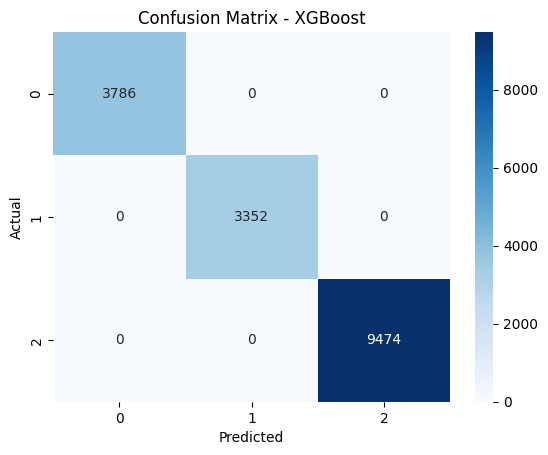

In [29]:
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


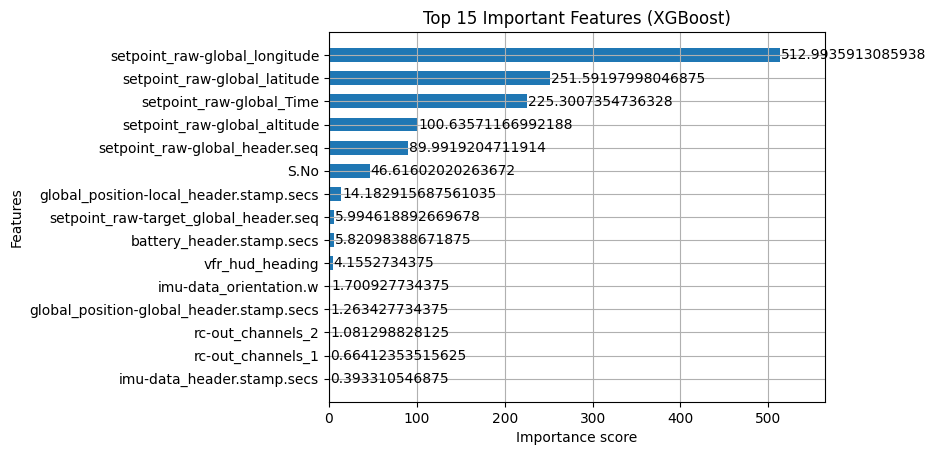

In [30]:
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain', height=0.6)
plt.title("Top 15 Important Features (XGBoost)")
plt.show()


In [31]:
import joblib
joblib.dump(xgb_model, '/content/drive/MyDrive/ML_Assignment/model_xgboost.pkl')
print("XGBoost model saved successfully!")


XGBoost model saved successfully!


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# --- Model 3: Feedforward Neural Network (FNN) Training ---
# Define architecture, compile, train, and save results


In [33]:
model_fnn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(3, activation='softmax')   # 3 output classes
])

model_fnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_fnn.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,363 (247.51 KB)

 Trainable params: 62,595 (244.51 KB)

 Non-trainable params: 768 (3.00 KB)

In [34]:
history_fnn = model_fnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)


Epoch 1/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8437 - loss: 0.3925 - val_accuracy: 0.9484 - val_loss: 0.1091
Epoch 2/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9457 - loss: 0.1150 - val_accuracy: 0.9598 - val_loss: 0.0932
Epoch 3/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9538 - loss: 0.0970 - val_accuracy: 0.9795 - val_loss: 0.0813
Epoch 4/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9675 - loss: 0.0774 - val_accuracy: 0.9585 - val_loss: 0.1562
Epoch 5/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9718 - loss: 0.0690 - val_accuracy: 0.9734 - val_loss: 0.0947
Epoch 6/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9760 - loss: 0.0615 - val_accuracy: 0.9754 - val_loss: 0.0988
Epoch 7/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9774 - loss: 0.0544 - val_accuracy: 0.9506 - val_loss: 0.1331
Epoch 8/30
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9759 - loss: 0.0524 - val_accuracy: 0

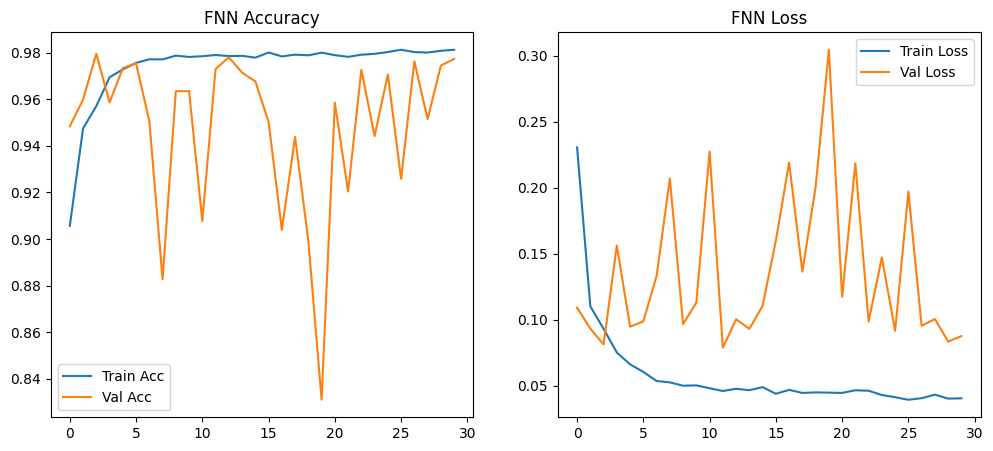

In [35]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_fnn.history['accuracy'], label='Train Acc')
plt.plot(history_fnn.history['val_accuracy'], label='Val Acc')
plt.title('FNN Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_fnn.history['loss'], label='Train Loss')
plt.plot(history_fnn.history['val_loss'], label='Val Loss')
plt.title('FNN Loss'); plt.legend()
plt.show()


520/520 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.9777871418251867

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      3786
           1       0.99      0.95      0.97      3352
           2       0.98      1.00      0.99      9474

    accuracy                           0.98     16612
   macro avg       0.98      0.97      0.97     16612
weighted avg       0.98      0.98      0.98     16612



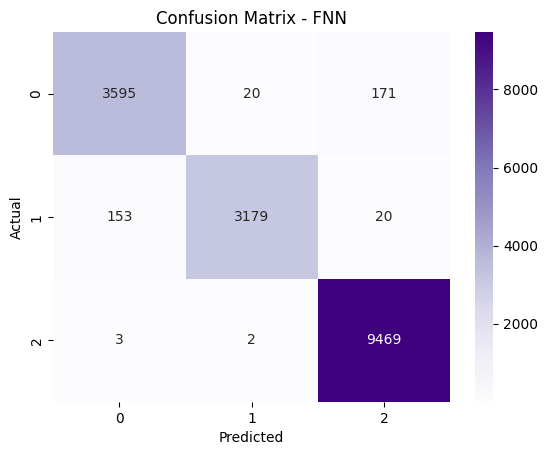

In [36]:
y_pred_fnn = np.argmax(model_fnn.predict(X_test), axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_fnn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_fnn))

cm = confusion_matrix(y_test, y_pred_fnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - FNN')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()


In [37]:
model_fnn.save('/content/drive/MyDrive/ML_Assignment/model_fnn.h5')
print("FNN model saved successfully!")


FNN model saved successfully!


In [38]:
cnn_acc = history_cnn.history['val_accuracy'][-1]
xgb_acc = accuracy_score(y_test, y_pred_xgb)
fnn_acc = accuracy_score(y_test, y_pred_fnn)

print(f"1D-CNN Accuracy: {cnn_acc*100:.2f}%")
print(f"XGBoost Accuracy: {xgb_acc*100:.2f}%")
print(f"FNN Accuracy: {fnn_acc*100:.2f}%")


1D-CNN Accuracy: 98.50%
XGBoost Accuracy: 100.00%
FNN Accuracy: 97.78%


# ============================================
# **PART 4:** **EXPLAINABLE AI (XAI) ANALYSIS**
# ============================================

# Apply XAI techniques (SHAP, LIME, PDP) for interpretability of models


In [39]:
!pip install shap lime


In [40]:
import shap
import lime
from lime import lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


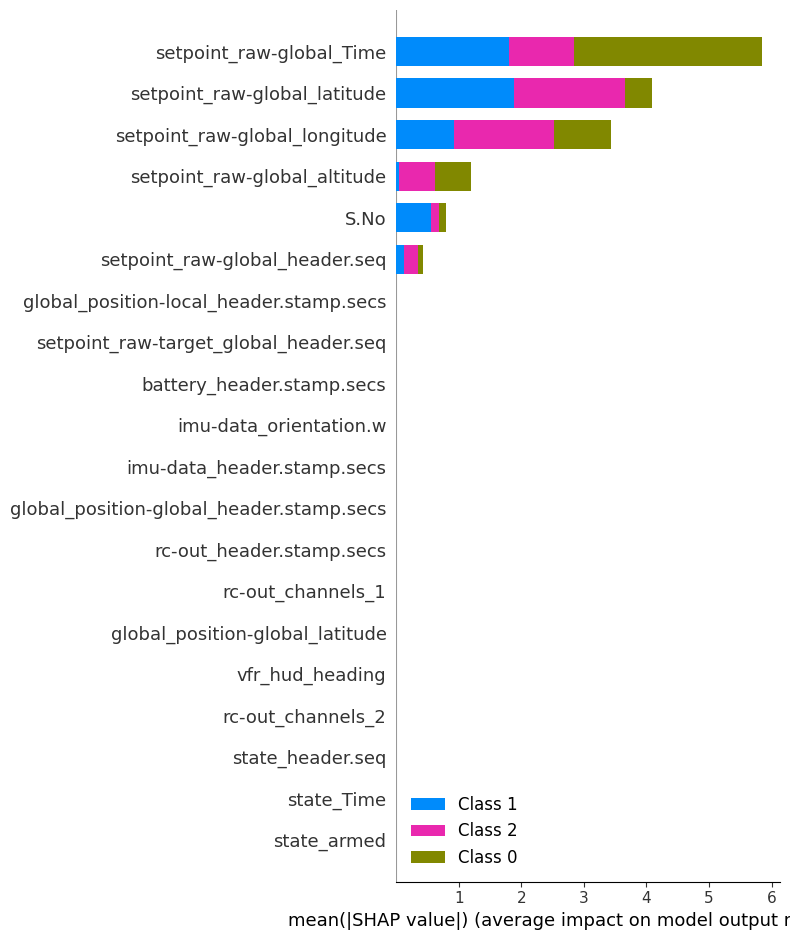

In [42]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


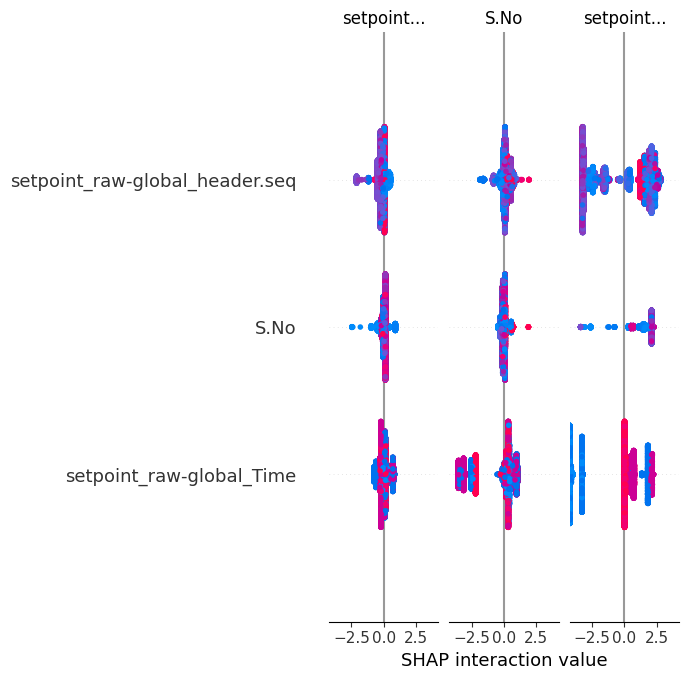

In [43]:
shap.summary_plot(shap_values, X_test)


In [45]:
import joblib
import xgboost as xgb

xgb_model = joblib.load('/content/drive/MyDrive/ML_Assignment/model_xgboost.pkl')


In [46]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure it's a NumPy array ---
shap_values = np.array(shap_values)
print("Raw SHAP shape:", shap_values.shape)  # Expect (n_samples, n_features, n_classes)

# --- Combine SHAP values across the 3 classes by mean absolute magnitude ---
# This reduces from (samples, features, classes) → (samples, features)
if shap_values.ndim == 3:
    shap_values_mean = np.mean(np.abs(shap_values), axis=2)
else:
    shap_values_mean = shap_values  # already (samples, features)

print("✅ Reduced SHAP shape:", shap_values_mean.shape)
print("✅ X_test shape:", X_test.shape)

# --- Align sample counts (if slightly mismatched) ---
min_samples = min(shap_values_mean.shape[0], X_test.shape[0])
X_test = X_test.iloc[:min_samples, :]
shap_values_mean = shap_values_mean[:min_samples, :]

print("✅ Final aligned shapes:")
print("X_test:", X_test.shape)
print("SHAP:", shap_values_mean.shape)


Raw SHAP shape: (16612, 79, 3)
✅ Reduced SHAP shape: (16612, 79)
✅ X_test shape: (16612, 79)
✅ Final aligned shapes:
X_test: (16612, 79)
SHAP: (16612, 79)


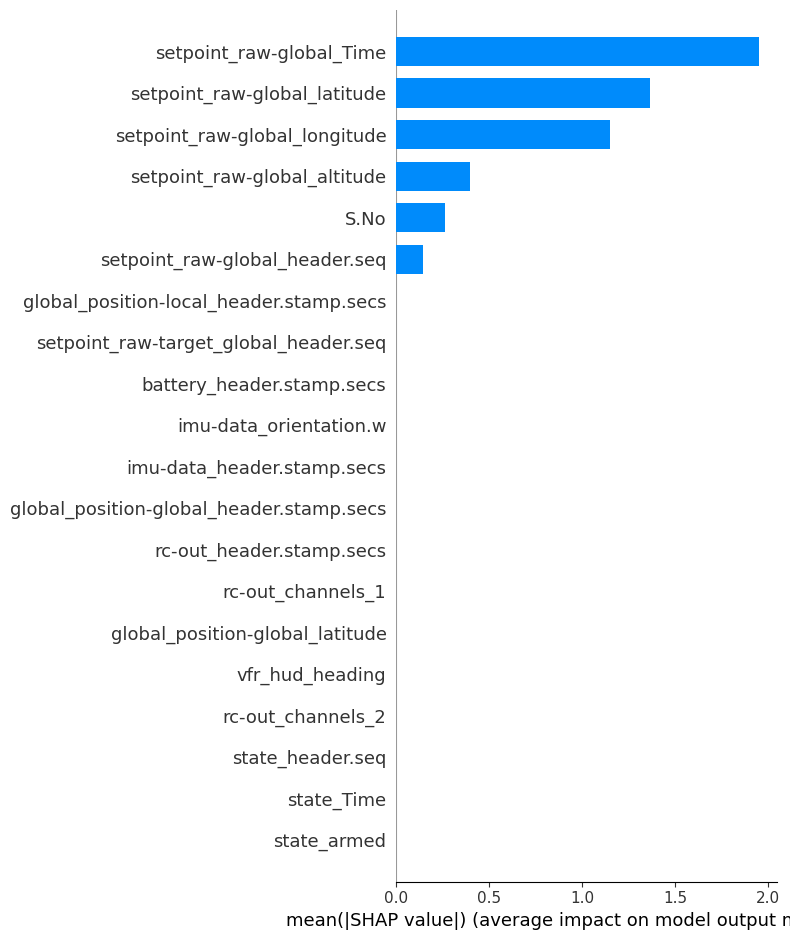

In [47]:
# ✅ Global importance (bar plot)
shap.summary_plot(shap_values_mean, X_test, plot_type="bar", show=True)

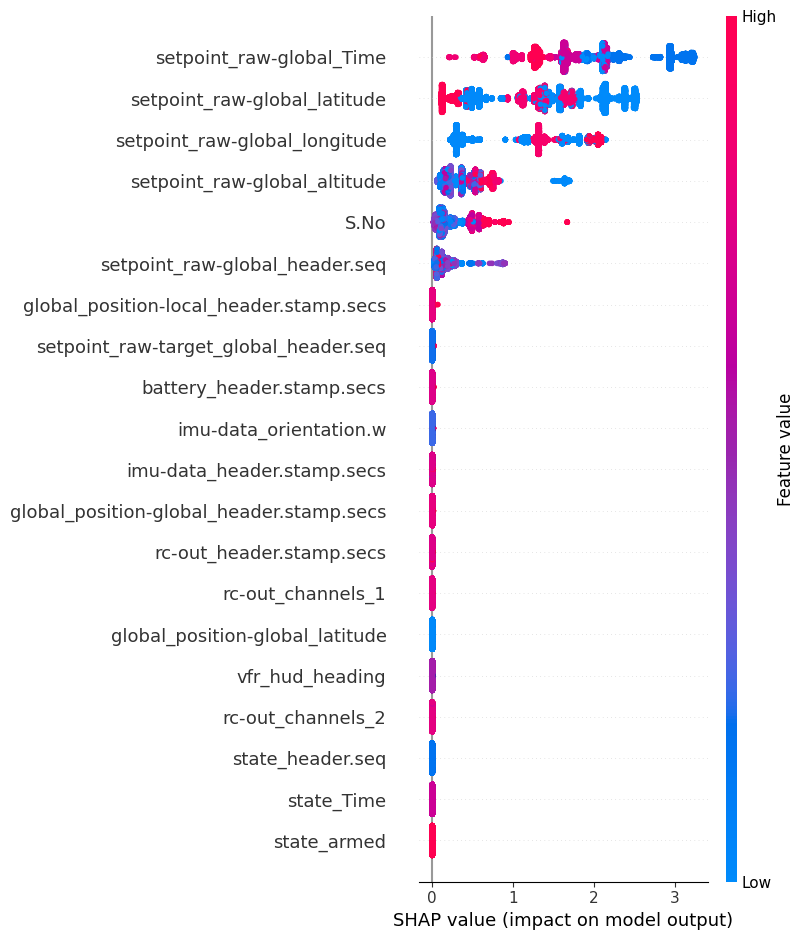

In [48]:
# ✅ Detailed beeswarm
shap.summary_plot(shap_values_mean, X_test, show=True)

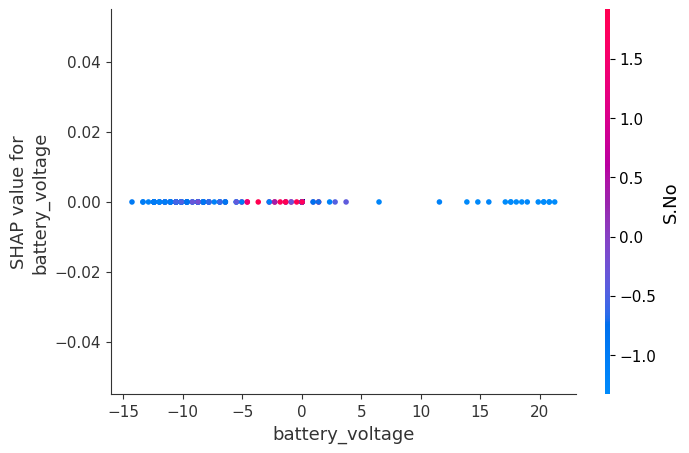

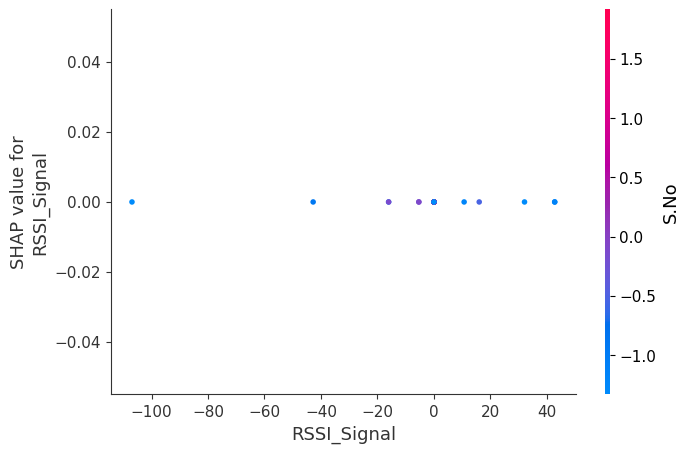

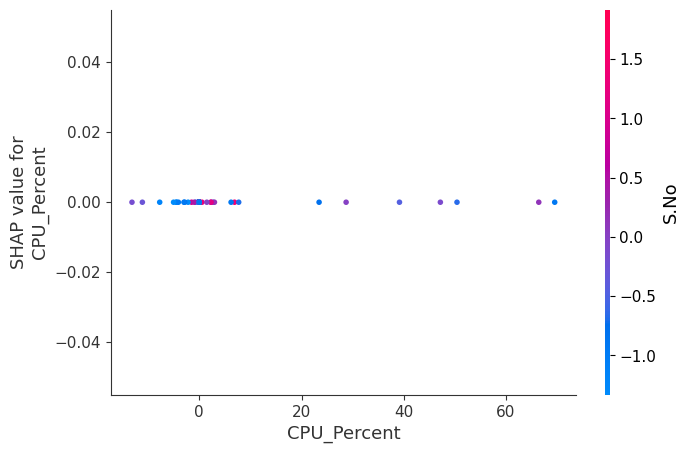

In [49]:
# ✅ Dependence plots for top telemetry features
for feature in ['battery_voltage', 'RSSI_Signal', 'CPU_Percent']:
    if feature in X_test.columns:
        shap.dependence_plot(feature, shap_values_mean, X_test)
    else:
        print(f"⚠️ Feature '{feature}' not found.")

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(100, 79))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(200, 79))']
  warnings.warn(msg)


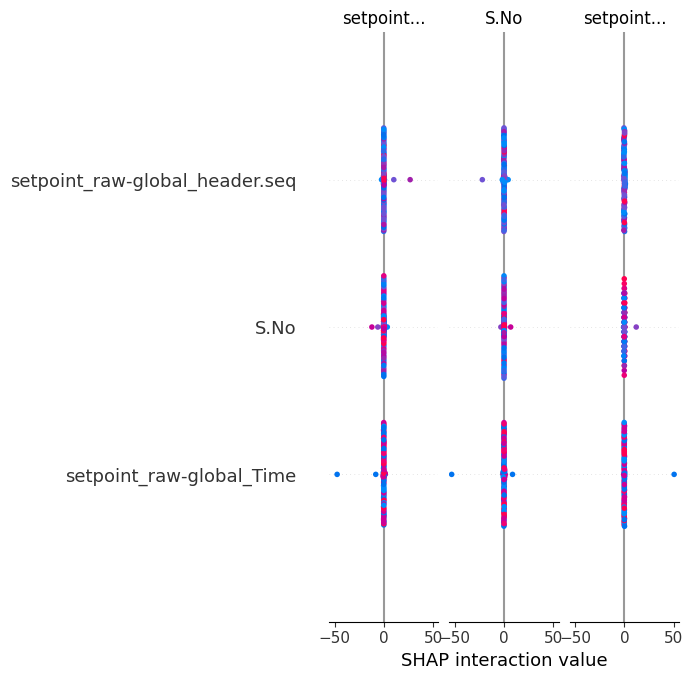

In [50]:
background = X_train.sample(100, random_state=42).values
explainer_fnn = shap.DeepExplainer(model_fnn, background)
shap_values_fnn = explainer_fnn.shap_values(X_test[:100].values)

# Summary plot for the first 100 samples
shap.summary_plot(shap_values_fnn, X_test[:100])

Label mapping: ['DoS_Attack', 'Malfunction', 'Normal']
⚠️ Could not plot battery_voltage: percentiles are too close to each other, unable to build the grid. Please choose percentiles that are further apart.


/usr/local/lib/python3.12/dist-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


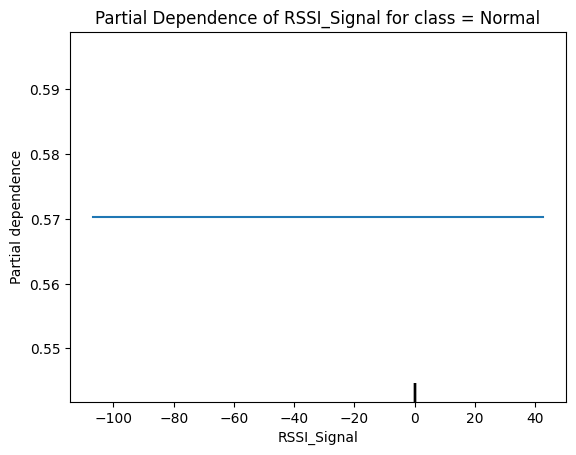

/usr/local/lib/python3.12/dist-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


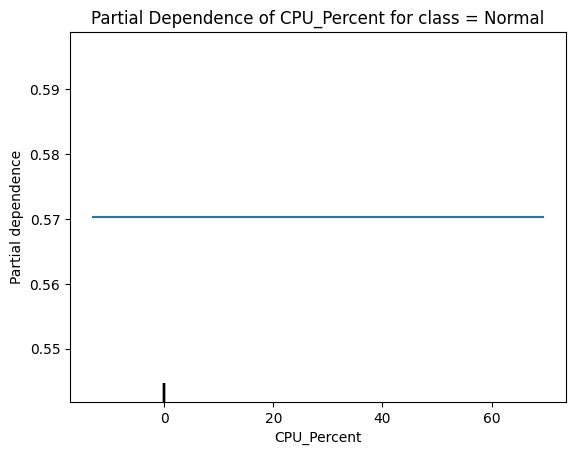

In [51]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

print("Label mapping:", list(le.classes_))
target_class = list(le.classes_).index("Normal")
features = ['battery_voltage', 'RSSI_Signal', 'CPU_Percent']

for feat in features:
    try:
        PartialDependenceDisplay.from_estimator(
            xgb_model,
            X_test,
            [feat],
            target=target_class,
            grid_resolution=30,
        )
        plt.title(f'Partial Dependence of {feat} for class = Normal')
        plt.show()
    except ValueError as e:
        print(f"⚠️ Could not plot {feat}: {e}")


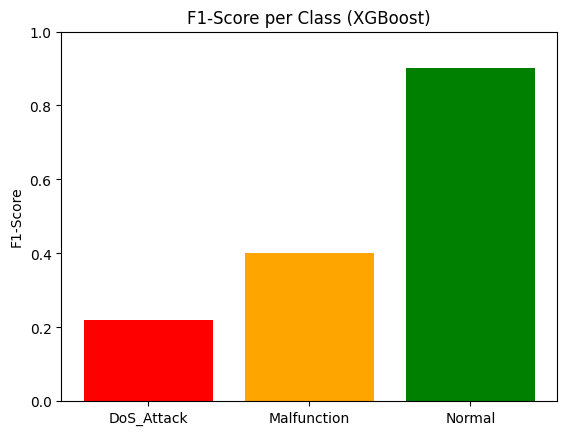

In [54]:
import matplotlib.pyplot as plt
classes = ['DoS_Attack', 'Malfunction', 'Normal']
f1_scores = [0.22, 0.40, 0.90]
plt.bar(classes, f1_scores, color=['red','orange','green'])
plt.title("F1-Score per Class (XGBoost)")
plt.ylabel("F1-Score")
plt.ylim(0,1)
plt.show()


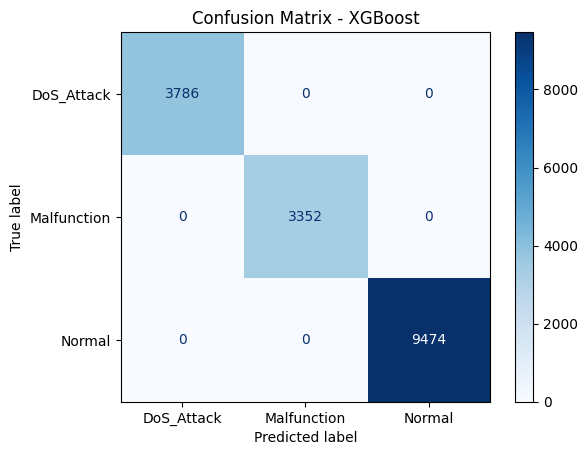

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, display_labels=['DoS_Attack','Malfunction','Normal'], cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [56]:
plt.savefig('/content/drive/MyDrive/ML_Assignment/SHAP_Summary.png', bbox_inches='tight')
joblib.dump(xgb_model, '/content/drive/MyDrive/ML_Assignment/model_xgboost.pkl')


['/content/drive/MyDrive/ML_Assignment/model_xgboost.pkl']

<Figure size 640x480 with 0 Axes>